In [1]:
import numpy as np
import cv2
import pandas as pd

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import numpy as np
import random
import math
from math import sin, cos, radians
from bresenham import bresenham

%matplotlib inline

In [2]:
mapsize=500

In [3]:
## locations with size from 1 to 10

sizes  =       [100,200,250,300,350,400,500,1000,2000,4000]
shapes =       [[10,10],[10,20],[10,25]  ,[15,20], [15,23], [20,20] ,[20,25] ,[25,40] ,[50,40]  ,[50,80]  ]
vernac =       [74,88,35,16,9,6,0,0,0,0] # urban/rural
worklocs =     [71,38,14, 9,6,1,0,0,0,0] # urban/industrial/rural
publicplaces = [0,0,0,0,6,5,4,3,2,1] ## (None,Garden,Square) (N,N,N,N,S,SG,SG,SG,G,G)
gardens =      [0,0,0,0,0,3,2,2,2,1]
plaza   =      [0,0,0,0,6,2,2,1,0,0]

In [4]:
lists_of_lists = [vernac, worklocs, publicplaces, gardens, plaza]
sz = [sum(x) for x in zip(*lists_of_lists)]
size_prob = [x/sum(sz) for x in sz]

In [5]:
def rotate_point(point, angle, translation, center_point=(0, 0)):
    """Rotates a point around center_point(origin by default)
    Angle is in degrees.
    Rotation is counter-clockwise
    """
    angle_rad = radians(angle % 360)
    (x,y) = translation
    # Shift the point so that center_point becomes the origin
    new_point = (point[0] - center_point[0], point[1] - center_point[1])
    new_point = (new_point[0] * cos(angle_rad) - new_point[1] * sin(angle_rad),
                 new_point[0] * sin(angle_rad) + new_point[1] * cos(angle_rad))
    # Reverse the shifting we have done
    new_point = (np.int32(new_point[0] + center_point[0] + x), np.int32(new_point[1] + center_point[1] + y))
    return new_point

### Start all 0

In [6]:
map_schem = np.zeros((mapsize,mapsize),dtype=np.uint8)
map_rot   = np.zeros((mapsize,mapsize),dtype=np.uint8)

UNUTILISED = 0
AVAILABLE_RD = 1
AVAILABLE_BLD = 2
ROAD = 3
BLD = 4

In [7]:
def draw_shape(pshape,location,rotation,show=False):
    ### Building, road and available site vectors 
    bld_poly =  [[0,0],[pshape[0],0],[pshape[0],pshape[1]],[0,pshape[1]]]
    road_line = [[0,-1],[pshape[0],-1]]
    avail_bld = [[0,-2],[pshape[0],-2]]
    
    ### Rotate Vectors
    bld_poly_rot = np.array([[rotate_point(z,rotation,location) for z in bld_poly]], dtype=np.int32)
    road_line_rot = [rotate_point(z,rotation,location) for z in road_line]
    avail_line_rot = [rotate_point(z,rotation,location) for z in avail_bld]
    
    
    ### Draw Vectors onto MAP
    ### Site might not be available
    cv2.line(map_schem,avail_line_rot[0],avail_line_rot[1],color=AVAILABLE_BLD,lineType=4)
    
    ### Road might already be present - check
    cv2.line(map_schem,road_line_rot[0],road_line_rot[1],color=ROAD,lineType=4)
    
    ### Locate building
    cv2.fillPoly(map_schem,bld_poly_rot,BLD)

    if show:
        plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(map_schem)

        plt.show()

In [8]:
def find_place(pshape):
    
    freeplace=0
    
    while freeplace<1:
        ### Find possible site
        site = 0
        while site == 0:
            (x,y) = (random.randint(0,mapsize-1),random.randint(0,mapsize-1))
            site = map_schem[x,y]
        score = []

        for angle in range(0,360,12):
            np = rotate_point([pshape[0],0],angle,(x,y)) 
            pixelpoints = bresenham(x,y,np[0],np[1])

            totalv=0
            for pixels in pixelpoints:
                (xx,yy) = pixels
                if  map_schem[xx,yy]==AVAILABLE_BLD:
                    totalv = totalv + 1
                else:
                    totalv = totalv - 1
            score.append(totalv)
            
        angle_at = 12*score.index(max(score))
        freeplace = max(score)
    return (x,y,180+angle_at)

In [9]:
draw_shape([10,20],(250,250),45)

### Start MAP

In [10]:
random_choice = np.random.choice(np.arange(1, 11), p=size_prob)

for buildings in range(10):
    bld = shapes[random_choice]
    (x,y,rot) = find_place(bld)
    draw_shape(bld,[x,y],rot)

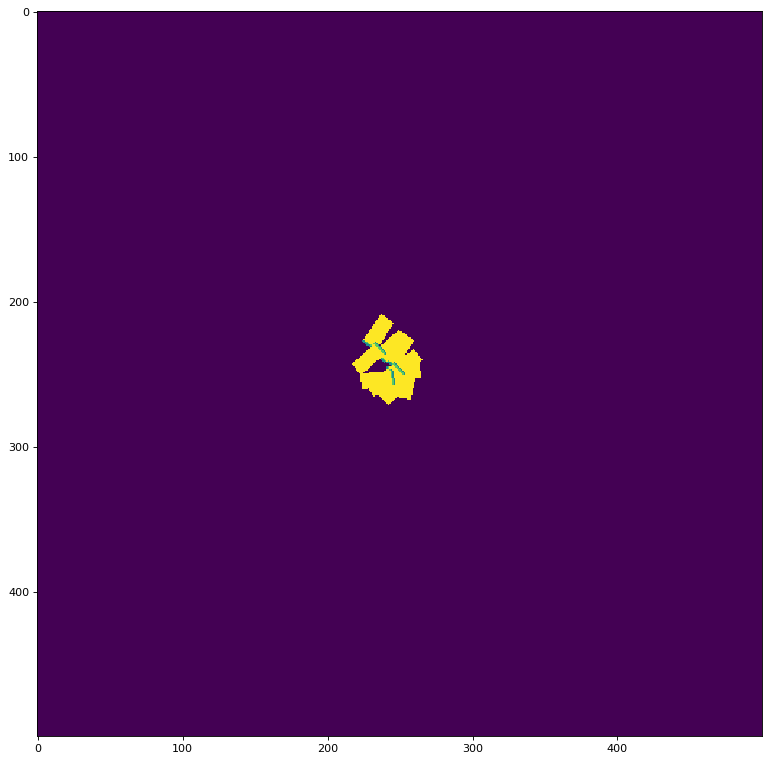

In [11]:
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(map_schem)

plt.show()